# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

In [6]:

def f_write_config(input_dict,fname):
    
    with open(fname,'w') as f:
        yaml.dump(input_dict,f,sort_keys=False)
    
def f_read_config(fname):
    
    with open(fname,'r') as f:
        config_dict=yaml.load(f, Loader=yaml.SafeLoader)
        
    return config_dict

### Gather observables

In [7]:
def f_get_plaquette(fname,dict1):
    
    try: 
        cmd="grep 'Plaquette' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string        

        arr=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), np.float64(i.split(' ')[-1])] 
                         for i in op])
        
        ## Hack for when Plaquette is printed twice : smeard and unsmeared
        arr=arr[0::2]
        
        dict1['Plaquette']=arr[:,1]
        dict1['iter'] = arr[:,0]
        
    except Exception as e: 
        print("Couldn't extract Plaquette values")
        print(e)
    
    return dict1

def f_get_polyakov(fname,dict1):
    
    try: 
        cmd="grep 'Polyakov' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        arr=[]
        for i in op: 
            strg=i.split(' ')[-1][1:-1]
            arr.append(complex(np.float64(strg.split(',')[0]),np.float64(strg.split(',')[1])))
    
        dict1['Polyakov']=arr

    except Exception as e: 
        print("Couldn't extract Polyakov values")
        print(e)
    
    return dict1


def f_get_traj_time(fname,dict1):
    
    try: 
        cmd="grep 'Total time for trajectory' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string
        
        arr=[np.float32(i.split(': ')[-1]) for i in op]
        dict1['Traj_time']=arr

    except Exception as e: 
        print("Couldn't extract total Traj times")
        print(e)
        
    return dict1



def f_get_metropolis(fname,dict1,lgth):
    
    try: 
        cmd="grep 'Metropolis_test' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        ## Other arrays have equilibriation data, metropolis doesn't. So we need to add nans to make them the same size
        arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
        skip=lgth-len(arr_temp)
        arr_skip=[np.nan for i in range(skip)]
        arr=np.array(arr_skip+arr_temp)
        dict1['Accept']=arr

    except Exception as e: 
        print("Couldn't extract total Metropolis info")
        print(e)
    
    return dict1

def f_parse_grid_data(fname):
    
    dict1={}
    
    f_get_plaquette(fname,dict1)
    
    f_get_polyakov(fname,dict1)
    
    f_get_traj_time(fname,dict1)    
    
    ## Check if list sizes are unequal
    size_lst=[len(val) for val in dict1.values()]
    lg=size_lst[0]
    for i in size_lst:
        if i!=lg: 
            print("Unequal sizes of dict elements")
            print([(key,len(val)) for key,val in dict1.items()])
    
    lgth = min([len(i) for i in dict1.values()])
    f_get_metropolis(fname,dict1,lgth)

    ## Store in DataFrame
    df=pd.DataFrame([])
    for key in dict1.keys():
        df[key]=pd.Series(dict1[key])
        
    return df

# df=f_parse_grid_data(fname)

In [8]:
def f_jackknife(arr):
    # Jackknife an input array to get sdev 
    
    N=arr.shape[0]
    arr_samples=np.zeros(N) # Array to store samples
    
    for i in range(N):
        arr2=np.delete(arr,i)
        arr_samples[i]=np.mean(arr2)
    
    # Compute mean and std. deviation
    mean=np.mean(arr_samples)
    err=np.sqrt( np.sum((arr_samples-mean)**2) * ((N-1)/N) ) # sqrt( (N-1) * variance ) for jackknife
#     err2=np.std(arr_samples)
#     print(err,err2)

    return gv.gvar(mean,err)
    
# arr=np.random.normal(5,1,10)
# f_jackknife(arr)

In [9]:
def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
#     m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         m[i]=gv.dataset.avg_data(y**i)
        
    ## Check moments obtained by gvar, with direct calculation
#     n=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     n[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         arr=y**i
#         n[i]=gv.gvar(np.mean(arr),np.std(arr)/np.sqrt(arr.shape[0]))
    
#     sus=(L**3)*(m[2]-(m[1]**2))
#     kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)

    
    ## Propagating errors for high correlated variables doesn't work, so we use jackknife
    ### Compute arrays of moments
    m=[y**i for i in range(0,5)] # List to store powers of input
    
    ## Compute sus and kurt by jackknifing elements of this list
    arr=(y-np.mean(y))**2
    sus=(L**3) * f_jackknife(arr)
#     print(sus)
    
    if sus>1e-7:
#         arr=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
        arr=((y-np.mean(y))**4)
        kurt= f_jackknife(arr) / (gv.mean(sus)**2)
    else: kurt=gv.gvar(np.nan,np.nan)
    return sus,kurt

    
    
    
def f_get_summary_data(df,L,dict1,equil=30):
    drop_idx=equil
    
    if df.shape[0]<=equil:
        return dict1
    
    ## Plaquette 
    y=df.Plaquette.values[drop_idx:]
    dict1['plaq'] = gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_plaq'],dict1['kurt_plaq']=f_moments(y,L)
    
    ## Polyakov Loop
    y=np.abs(df.Polyakov.values[drop_idx:])
    dict1['polyakov']=gv.dataset.avg_data(y)
    
    # Susceptibility and Binder cumulant
    dict1['sus_poly'],dict1['kurt_poly']=f_moments(y,L)

    
    ## Trajectory time
    y=df.Traj_time.values[drop_idx:]
    dict1['traj_time']=gv.dataset.avg_data(y)
    
    
    ## Acceptance info
    y=df['Accept'].dropna().values
    Act=y[y==1].shape[0]
    Rjt=y[y==0].shape[0]
    accpt=Act* 100 /(Act+Rjt)

    dict1['accept']=accpt

    ## num of configs
    y=df.Plaquette.values[drop_idx:]
    dict1['num_conf']=y.shape[0]
    
    return dict1



$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] = L^3 \langle (\mathcal{O} - \bar{\mathcal{O}})^2\rangle $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2} = \frac{ \langle \left( \mathcal{O-\bar{\mathcal{O}}} \right) ^4 \rangle }{\chi_\mathcal{O}^2}$$ 

In [33]:

Lx='*'
Lt='*'
data_dict={}
df_summary=pd.DataFrame([])

# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/'
# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram/'
# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/'
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/'


flist=glob.glob(top_dir+'run_Lx-%s_Lt-%s*'%(Lx,Lt))
# print(flist)

equil=50
print("Equil",equil)

for run_fldr in flist: 
    fname=run_fldr+'/HSDM.out'
#     print(fname)
    
    if not os.path.isfile(fname): 
        print("File %s doesn't exist"%(fname))
        continue
        
    # Read config file from folder
    input_dict=f_read_config(run_fldr+'/config.yaml')
    
    try : 
        df=f_parse_grid_data(fname)
#     display(df)
    except Exception as e:
        print(e,fname)
        continue
    
    if equil>=df.shape[0]:
        print("Skipping %s, not enough configs"%(fname))
        continue
    
    key='beta-%s_mf-%s_Lx-%s_Lt-%s'%(input_dict['beta'],input_dict['mf'],input_dict['Lx'],input_dict['Lt'])
    
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        key+='_Ls-%s'%(input_dict['dwf_Ls'])
    
    count=1
    while(key in data_dict.keys()): # If duplicate key, add suffix
        print("Key exists",key,fname)
        count+=1
        key=key+'_%s'%(count)
        if count>10: break
        
    data_dict[key]=df
    
    # Get summary data
    dict2={}
    for key in ['beta','mf','Lx','Lt']:   dict2[key]=input_dict[key]
    if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
        dict2['Ls']=input_dict['dwf_Ls']
    dict2=f_get_summary_data(df,input_dict['Lx'],dict2,equil)
        
    df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
# Drop rows with no values
df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)
display(df_summary)


Equil 50
Couldn't extract total Metropolis info
Command 'grep 'Metropolis_test' /usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.8_mf-0.1/HSDM.out' returned non-zero exit status 1.
Skipping /usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.8_mf-0.1/HSDM.out, not enough configs
Couldn't extract total Metropolis info
Command 'grep 'Metropolis_test' /usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-24_Lt-8_Ls-16_beta-10.0_mf-0.1/HSDM.out' returned non-zero exit status 1.
Skipping /usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-24_Lt-8_Ls-16_beta-10.0_mf-0.1/HSDM.out, not enough configs
Couldn't extract total Metropolis info
Command 'grep 'Metropolis_test' /usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diag

,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept,num_conf
0,10.0,0.1,16,8,16,0.413527(62),0.00189(31),2.5(1.0)e-07,0.00354(16),0.0129(22),2.7(1.4)e-07,141.403(22),78.125000,120
1,10.2,0.1,16,8,16,0.442378(89),0.00384(45),1.55(31)e-07,0.00337(15),0.0108(12),1.44(29)e-07,142.857(26),88.607595,118
2,10.4,0.1,16,8,16,0.51334(24),0.0303(20),9.3(1.3)e-08,0.00340(15),0.0118(17),2.16(91)e-07,134.351(93),92.215569,127
3,10.4,0.1,24,8,16,0.51231(27),0.0625(92),1.20(36)e-08,0.00194(13),0.0134(23),1.42(51)e-08,321.20(23),95.000000,60
4,10.6,0.1,16,8,16,0.547152(63),0.00250(25),1.50(30)e-07,0.00442(17),0.0191(22),1.79(46)e-07,114.31(24),96.391753,154
5,10.6,0.1,24,8,16,0.547001(55),0.00302(46),1.40(36)e-08,0.00277(17),0.0292(30),9.3(1.6)e-09,281.25(70),87.610619,73
6,10.6,0.1,24,12,16,0.546901(45),0.00099(18),1.11(45)e-08,0.00221(21),0.0215(51),1.54(58)e-08,402.73(84),89.333333,35
7,10.8,0.1,16,8,16,0.564422(44),0.00130(14),1.69(32)e-07,0.00598(26),0.0458(66),2.53(89)e-07,99.51(10),94.500000,160
8,10.8,0.1,24,8,16,0.564332(34),0.00140(20),1.42(45)e-08,0.00533(20),0.0492(69),1.43(37)e-08,243.84(54),91.472868,89
9,11.0,0.1,16,8,16,0.578146(42),0.00114(11),1.45(25)e-07,0.00847(39),0.099(14),2.45(83)e-07,95.311(98),96.000000,160


In [38]:
# df_summary[df_summary.beta==10.8]
df_summary[df_summary.Lx==16]
# display(df_summary)

,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept,num_conf
0,10.0,0.1,16,8,16,0.413527(62),0.00189(31),2.5(1.0)e-07,0.00354(16),0.0129(22),2.7(1.4)e-07,141.403(22),78.125000,120
1,10.2,0.1,16,8,16,0.442378(89),0.00384(45),1.55(31)e-07,0.00337(15),0.0108(12),1.44(29)e-07,142.857(26),88.607595,118
2,10.4,0.1,16,8,16,0.51334(24),0.0303(20),9.3(1.3)e-08,0.00340(15),0.0118(17),2.16(91)e-07,134.351(93),92.215569,127
4,10.6,0.1,16,8,16,0.547152(63),0.00250(25),1.50(30)e-07,0.00442(17),0.0191(22),1.79(46)e-07,114.31(24),96.391753,154
7,10.8,0.1,16,8,16,0.564422(44),0.00130(14),1.69(32)e-07,0.00598(26),0.0458(66),2.53(89)e-07,99.51(10),94.500000,160
9,11.0,0.1,16,8,16,0.578146(42),0.00114(11),1.45(25)e-07,0.00847(39),0.099(14),2.45(83)e-07,95.311(98),96.000000,160
12,11.2,0.1,16,8,16,0.590210(36),0.000860(99),1.86(44)e-07,0.02613(93),0.573(47),1.24(18)e-07,94.07(15),96.000000,160
14,11.4,0.1,16,8,16,0.601230(36),0.00086(10),1.93(47)e-07,0.0230(12),0.90(11),2.11(44)e-07,91.76(19),96.000000,160
16,11.6,0.1,16,8,16,0.611008(38),0.00095(11),1.95(57)e-07,0.0250(10),0.705(56),1.20(16)e-07,92.31(17),92.000000,160
19,12.0,0.1,16,8,16,0.629435(35),0.000791(91),1.85(42)e-07,0.08022(83),0.447(55),2.01(41)e-07,78.93(23),96.500000,160


In [23]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.2_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.4_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-11.6_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16', 'beta-10.0_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.2_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.4_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.6_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.8_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-11.0_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-11.2_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-11.4_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-11.8_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-12.0_mf-0.1_Lx-24_Lt-8_Ls-16', 'beta-10.6_mf-0.1_Lx-24_Lt-12_Ls-16', 'beta-11.0_mf-0.1_Lx-24_Lt-12_Ls-16', 'beta-11.6_mf-0.1_Lx-24_Lt-12_Ls-16', 'beta-12.0_mf-0.1_Lx-24_Lt-12_Ls-16'])

## Summary plots

In [35]:
mf_list   = np.sort(np.unique(df_summary.mf.values))
beta_list = np.sort(np.unique(df_summary.beta.values))
# Lt_list = np.sort(np.unique(df_summary.Lt.values))

## Combining Lx and Lt into a label 
L_list=np.unique([str(i)+'_'+str(j) for i,j in zip(df_summary.Lx.values, df_summary.Lt.values)])

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


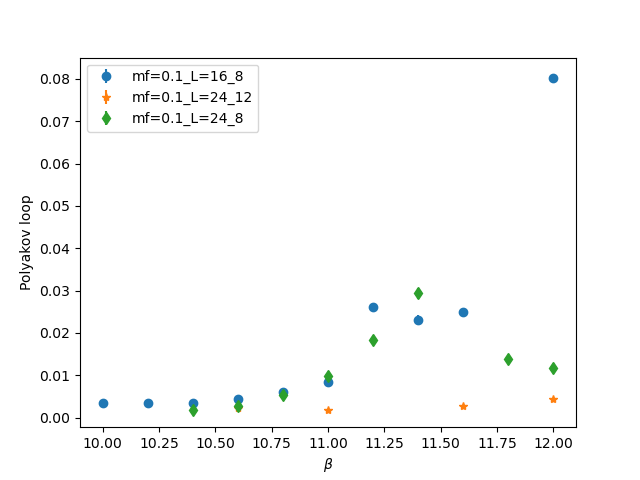

In [39]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_summary[(df_summary.Lx==lx)&(df_summary.Lt==lt)]
    for mf in mf_list:
        label='mf=%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.polyakov.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        
plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
plt.savefig('Ploop_vs_beta.pdf')

### Plaquette vs beta

<IPython.core.display.Javascript object>


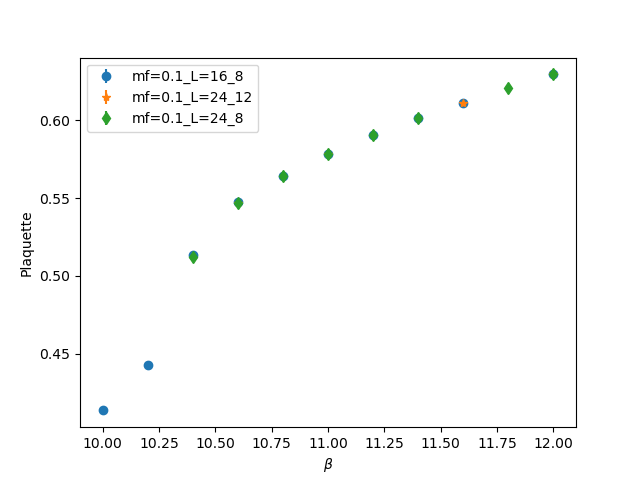

In [40]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_summary[(df_summary.Lx==lx)&(df_summary.Lt==lt)]
    for mf in mf_list:
        label='mf=%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.plaq.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Plaquette',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
plt.savefig('Plaq_vs_beta.pdf')

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [50]:
# plt.figure()

# for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
#     lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
#     df=df_summary[(df_summary.Lx==lx)&(df_summary.Lt==lt)]
#     for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):
#         label='beta=%s_l=%s'%(beta,l)
#         df1=df[df.beta==beta].sort_values(by=['mf'])
#     #     display(df1)

#     #     if df1.shape[0]>1:
#         x=df1.mf.values
#         y=df1.polyakov.values
#     #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

# plt.xlabel(r'$m_f$')
# # plt.xticks(mf_list)
# # plt.xlim(-0.5,2.0)
# plt.legend(loc='best')
# plt.ylabel('Polyakov loop',rotation='vertical')
# # plt.savefig('Ploop_vs_mf.pdf')

### Plot Susceptibility

<IPython.core.display.Javascript object>


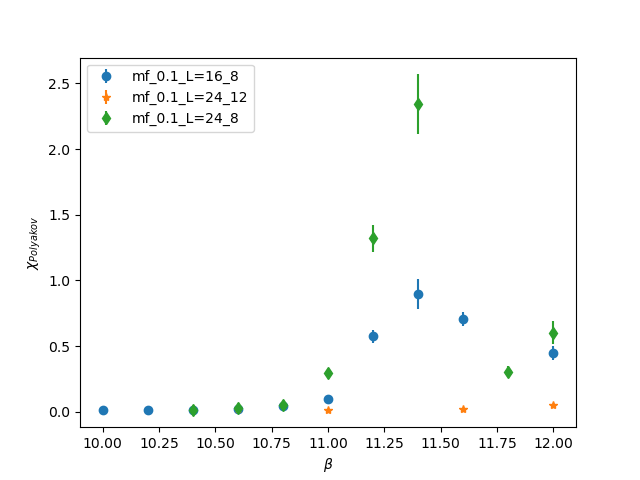

In [43]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_summary[(df_summary.Lx==lx)&(df_summary.Lt==lt)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.sus_poly.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Polyakov}$',rotation='vertical')
plt.savefig('chi_poly_vs_beta.pdf')

<IPython.core.display.Javascript object>


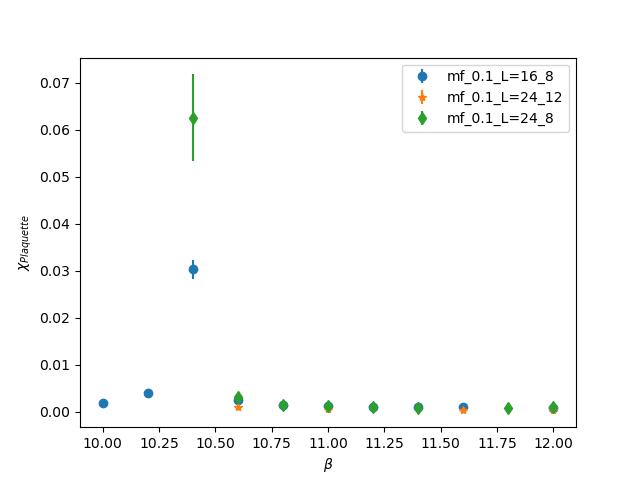

In [42]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_summary[(df_summary.Lx==lx)&(df_summary.Lt==lt)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.sus_plaq.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Plaquette}$',rotation='vertical')
plt.savefig('chi_plaq_vs_beta.pdf')

<IPython.core.display.Javascript object>


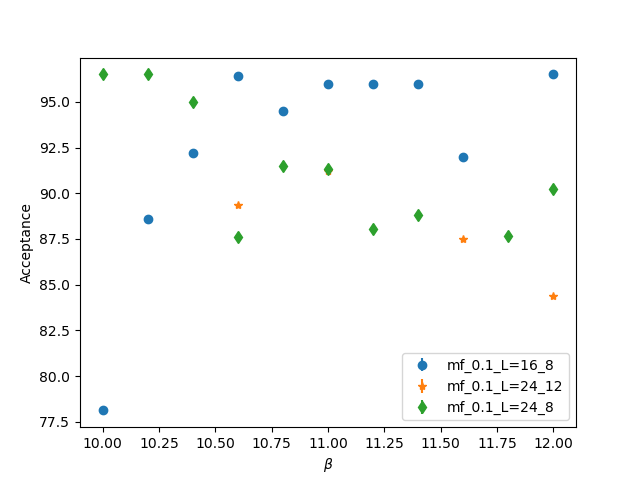

Text(0, 0.5, 'Acceptance')

In [30]:
# Plot acceptance rate 

# plt.figure()

# for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

#     label='beta_%s'%(beta)
#     df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
# #     display(df1)
    
# #     if df1.shape[0]>1:
#     x=df1.mf.values
#     y=df1.accept.values
# #     print(x,y)
#     plt.plot(x,y,linestyle='',label=label,marker=marker)
# #     plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

# plt.xlabel(r'$m_f$')
# # plt.xticks(mf_list)
# # plt.xlim(-0.5,2.0)
# plt.legend(loc='best')
# plt.ylabel('Acceptance',rotation='vertical')
# # plt.savefig('Acceptance_vs_mf.pdf')


plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_summary[(df_summary.Lx==lx)&(df_summary.Lt==lt)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.accept.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Acceptance',rotation='vertical')
# plt.savefig('Acceptance_vs_beta.pdf')


In [ ]:
df1

## Individual plots

In [ ]:
data_dict.keys()

In [ ]:

def f_plot_specific_runs(data_dict,column,keys_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    assert len(keys_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):

        df=data_dict[i]
        label=i
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    
    
# beta_list=[9.0,10.0,10.2,10.4,10.5,10.6,10.8]
beta_list=[10.2,10.6,11.2][:]
mf_list=[0.1]
## Gather dict keys with given beta and mf values
Ls=16
Lt=8
keys_list=['beta-%s_mf-%s_Lx-16_Lt-%s_Ls-%s'%(b,m,Lt,Ls) for m in mf_list for b in beta_list]

f_plot_specific_runs(data_dict,'Plaquette',keys_list)
plt.savefig('Plaq_details.pdf')

# f_plot_specific_runs(dict_list,'Traj_time',keys_list)

f_plot_specific_runs(data_dict,'Polyakov',keys_list)
plt.savefig('Polyakov_details.pdf')


In [ ]:
f_plot_specific_runs(data_dict,'Accept',keys_list)


### Plot Polyakov loop

In [ ]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


In [ ]:
data_dict.keys()

In [ ]:
keys_list

In [ ]:
keys_list=['beta-%s_mf-%s_Lx-16_Lt-8_Ls-16'%(b,m) for m in mf_list for b in beta_list]


fig=plt.figure()

for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):
    df=data_dict[i]
    label=i
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

In [ ]:
# Histogram
beta=10.8
mf=0.1
key='beta-%s_mf-%s_Lx-16_Lt-8_Ls-16'%(beta,mf)

df=data_dict[key]

fig=plt.figure()
x=df.iter.values[:210]
y=np.abs(df.Polyakov.values[:210])

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=50,color='b')

plt.title("Polyakov loop Histogram for beta: %s"%(beta))
plt.savefig('ploop_histogram.pdf')